# 1. Introduction

## 1.1 Scenario

    Saya adalah seorang Data Scientist di Kalbe Nutritionals dan sedang mendapatkan project baru dari tim inventory dan tim marketing.
    - Tim inventory meminta untuk dapat membantu memprediksi jumlah penjualan (quanity) dari total keseluruhan product kalbe.
    - Tim marketing meminta untuk membuat cluster/segment customer berdasarkan beberapa kriteria.

## 1.2 Objective and Goals

    Objective dan tujuan dari proyek ini adalah:
    1. Untuk mengetahui perkiraan quantity product yang terjual sehingga tim inventory dapat membuat stock persediaan harian yang cukup.
    2. Untuk membuat segment customer yang akan digunakan tim marketing untuk memberikan personalizes promotion dan sales treatment.

# 2. Import Library

In [121]:
import warnings
warnings.filterwarnings('ignore')

# Librari untuk mengolah data
import pandas as pd
import numpy as np

# Librari untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns 

# For Component Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from jcopml.time_series.decomposition import additive_decomposition

from sklearn import preprocessing

# Librari untuk model forecasting (ARIMA)
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA 

# Librari untuk model Clustering KMeans
from sklearn.cluster import KMeans

# Librari untuk evaluasi
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import silhouette_score

# Librari untuk menyimpan model
import joblib
import json


# 3. Loading Data

## 3.1 Loading Data

In [59]:
# Loading dataset
transaction = pd.read_csv('G:\Data-Scientist Project-Based-Internship-Program\Kalbe-Nutritionals\Final-project\Data\Transaction.csv')
store = pd.read_csv('G:\Data-Scientist Project-Based-Internship-Program\Kalbe-Nutritionals\Final-project\Data\Store.csv')
product = pd.read_csv('G:\Data-Scientist Project-Based-Internship-Program\Kalbe-Nutritionals\Final-project\Data\Product.csv')
customer = pd.read_csv('G:\Data-Scientist Project-Based-Internship-Program\Kalbe-Nutritionals\Final-project\Data\Customer.csv')

In [60]:
# Copy dataset
copy_transaction = transaction.copy()
copy_store = store.copy()
copy_product = product.copy()
copy_customer = customer.copy()

In [61]:
# melihat 5 data teratas tabel transaction
transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,1/1/2022,P3,7500,4,30000,12
1,TR16356,165,1/1/2022,P9,10000,7,70000,1
2,TR1984,183,1/1/2022,P1,8800,4,35200,4
3,TR35256,160,1/1/2022,P1,8800,7,61600,4
4,TR41231,386,1/1/2022,P9,10000,1,10000,4


In [62]:
# melihat 5 data teratas tabel store
store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2",106816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6914864,107608238
2,3,Prima Kota,Prima,Modern Trade,-7797068,110370529
3,4,Gita Ginara,Gita,General Trade,-6966667,110416664
4,5,Bonafid,Gita,General Trade,-7250445,112768845


In [63]:
# melihat 5 data teratas tabel customer
customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [64]:
# melihat 5 data teratas tabel product
product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [65]:
# Memeriksa duplikasi data
print(f'Jumlah data duplikate transaction: {transaction.duplicated().sum()}')
print(f'Jumlah duplikasi data store : {store.duplicated().sum()}')
print(f'Jumlah duplikasi data product: {product.duplicated().sum()}')
print(f'Jumlah duplikasi data customer: {customer.duplicated().sum()}')

Jumlah data duplikate transaction: 0
Jumlah duplikasi data store : 0
Jumlah duplikasi data product: 0
Jumlah duplikasi data customer: 0


**Insight:**
Data tidak memiliki data yang duplikat

In [66]:
# Memeriksa infromasi tabel transaction
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


**Insight:**
1. DataFrame memiliki 5020 baris dan 8 kolom
2. Tipe data kolom terdiri dari 3 object dan 5 integer
3. Tidak memiliki missing value
4. Data yang perlu diatasi:
    - Tipe data kolom `Date` akan diganti manjadi tanggal

In [67]:
# Memeriksa informasi data tabel customer
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


**Insight:**
1. DataFrame memiliki 447 baris dan 5 kolom
2. Tipe data kolom terdiri dari 2 object dan 3 integer
3. Memiliki missing value pada kolom `Marital Status`
4. Data yang perlu diatasi:
    - Tipe data kolom `Gender` akan diganti manjadi boolean
    - Tipe data kolom `Income` akan diganti menjadi integer
    - Missing value pada kolom `Marital Status`
    - Rename kolom `Marital Status` menjadi `MaritalStatus`

In [68]:
# Melihat missing values pada kolom customer
customer.isna().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

**Insight:**
Terdapat 3 missing value pada kolom `Marital Status`

In [69]:
# Memeriksa informasi data pada kolom product
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


**Insight:**
1. DataFrame memiliki 10 baris dan 3 kolom
2. Tipe data kolom terdiri dari 2 object dan 1 integer
3. Tidak ada missing value
4. Data yang perlu diatasi:
    - Rename kolom `Product Name` menjadi `ProductName`

In [70]:
# Memeriksa informasi data kolom store
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 800.0+ bytes


**Insight:**
1. DataFrame memiliki 14 baris dan 6 kolom
2. Tipe data kolom terdiri dari 4 object dan 2 integer
3. Tidak Memiliki missing value

## 3.2 Cleaning and Manipulation Data

In [71]:
# Merubah tipe data tabel transaction
transaction['Date'] = pd.to_datetime(transaction['Date'], format='%d/%m/%Y')

# Merubah tipe data tabel customer
customer['Income'] = customer['Income'].replace('[,]','.', regex=True).astype(float)

# Merubah tipe data tabel store
store['Latitude'] = store['Latitude'].replace('[,]','.', regex=True).astype(float)
store['Longitude'] = store['Longitude'].replace('[,]','.', regex=True).astype(float)

# Merubah nama kolom
product = product.rename(columns={'Product Name': 'ProductName'})
customer = customer.rename(columns={'Marital Status': 'MaritalStatus'})

In [72]:
# Merge all table into one

merged_df = pd.merge(transaction, product,on='ProductID', suffixes = ('_customers', '_product'))
merged_df = pd.merge(merged_df, store, on='StoreID')
final_merged_df = pd.merge(merged_df, customer, on='CustomerID')
df= final_merged_df.drop(['Price_customers'], axis = 1)
df.sample(5)

,TransactionID,CustomerID,Date,ProductID,Qty,TotalAmount,StoreID,ProductName,Price_product,StoreName,GroupStore,Type,Latitude,Longitude,Age,Gender,MaritalStatus,Income
978,TR48732,89,2022-09-19,P5,4,16800,5,Thai Tea,4200,Bonafid,Gita,General Trade,-7250445.00,112768845.0,32,0,Married,9.68
4822,TR76889,35,2022-03-15,P4,3,36000,1,Potato Chip,12000,Prima Tendean,Prima,Modern Trade,-6.20,106816666.0,48,1,Married,10.58
4428,TR92445,53,2022-11-16,P8,1,16000,1,Oat,16000,Prima Tendean,Prima,Modern Trade,-6.20,106816666.0,32,0,Married,7.36
4418,TR85173,53,2022-12-01,P7,3,28200,14,Coffee Candy,9400,Priangan,Priangan,Modern Trade,-5.45,10526667.0,32,0,Married,7.36
1194,TR15329,362,2022-02-13,P8,2,32000,2,Oat,16000,Prima Kelapa Dua,Prima,Modern Trade,-6914864.00,107608238.0,25,0,Single,7.47


In [73]:
# check dataframe info and shape
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   int64         
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Qty            5020 non-null   int64         
 5   TotalAmount    5020 non-null   int64         
 6   StoreID        5020 non-null   int64         
 7   ProductName    5020 non-null   object        
 8   Price_product  5020 non-null   int64         
 9   StoreName      5020 non-null   object        
 10  GroupStore     5020 non-null   object        
 11  Type           5020 non-null   object        
 12  Latitude       5020 non-null   float64       
 13  Longitude      5020 non-null   float64       
 14  Age            5020 non-null   int64         
 15  Gender         5020 n

(5020, 18)

In [74]:
# Aggregat kolom Date dan Qty untuk Forecasting
df_forecast = df.groupby(['Date']).agg({'Qty': 'sum'}).reset_index()

# Set kolom Date menjadi index
df_forecast = df_forecast.set_index('Date')
df_forecast.head(3)

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63


# 4. Data Exploratory Analysis (EDA)

Proses ini bertujuan untuk memahami karakteristik dasar dari dataset yang ada sebelum menjalankan model atau pengujian hipotesis tertentu.

## 4.1 Descriptive Analysis

In [119]:
df.describe()

,CustomerID,Date,Qty,TotalAmount,StoreID,Price_product,Latitude,Longitude,Age,Gender,Income
count,5020.000000,5020,5020.000000,5020.000000,5020.000000,5020.000000,5.020000e+03,5.020000e+03,5020.000000,5020.000000,5020.000000
mean,221.263745,2022-06-29 00:32:24.860557568,3.644622,32279.482072,7.489841,9684.800797,-2.424569e+06,9.519178e+07,40.003586,0.452988,8.623713
min,1.000000,2022-01-01 00:00:00,1.000000,7500.000000,1.000000,3200.000000,-7.797068e+06,1.052667e+07,0.000000,0.000000,0.000000
25%,108.000000,2022-03-30 00:00:00,2.000000,16000.000000,4.000000,4200.000000,-6.914864e+06,9.867851e+07,30.000000,0.000000,4.220000
50%,221.000000,2022-06-26 00:00:00,3.000000,28200.000000,7.000000,9400.000000,-2.990934e+06,1.076082e+08,39.000000,0.000000,7.720000
75%,332.000000,2022-09-28 00:00:00,5.000000,47000.000000,11.000000,15000.000000,5.335050e-01,1.127688e+08,51.000000,1.000000,10.780000
max,447.000000,2022-12-31 00:00:00,10.000000,88000.000000,14.000000,18000.000000,3.597031e+06,1.281906e+08,72.000000,1.000000,71.300000
std,129.672955,NaN,1.855295,19675.462455,4.028502,4600.708780,3.806625e+06,3.506809e+07,12.834719,0.497835,6.518242


**Dari statistik deskriptif diatas, diperoleh beberapa insight:**
1. **Price:**
- Rata-rata harga Rp. 9,685
- Harga produk paling rendah sebesar Rp.3,200, paling tinggi Rp. 18,000.
2. **Kuantiti (Qty)**
- Rata-rata produk terjual sebanyak 4 unit
- Penjualan paling rendah 1 dan penjualan paling tinggi sebanyak 10
3. **Total Amount**
- Rata-rata Total Amount sekitar Rp. 32,279
- Total Amount minimum adalah sekitar Rp. 7,500, sedangkan penjualan maksimum harian sekitar Rp. 88,000
4. **Age**
- Rata-rata usia customer berumur 40 tahun
- Usia customer paling rendah yaitu 0 besar kemungkinan usia 0 ini adalah missing value, sedangkan usia paling tinggi yaitu 72 tahun
5. **Income**
- Rata-rata pedapatan customer sebesar Rp 8,6 Juta
- Pendapatan minimum customer adalah 0, sedangkan pendapatan maksimum sekitar Rp. 71,3 Juta


## 4.2 Trend Analysis

<Axes: xlabel='Date'>

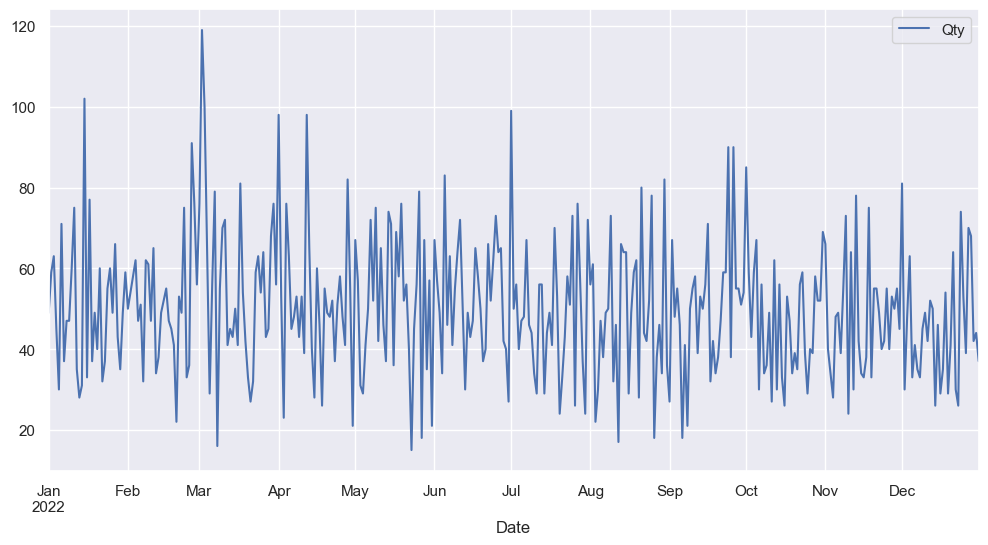

In [120]:
df_forecast.plot(figsize=(12,6))

Jika dilihat plot diatas, data tidak memiliki trend dan seasonal, data cenderung stationer, untuk memperjelas mari kita cek decomposition

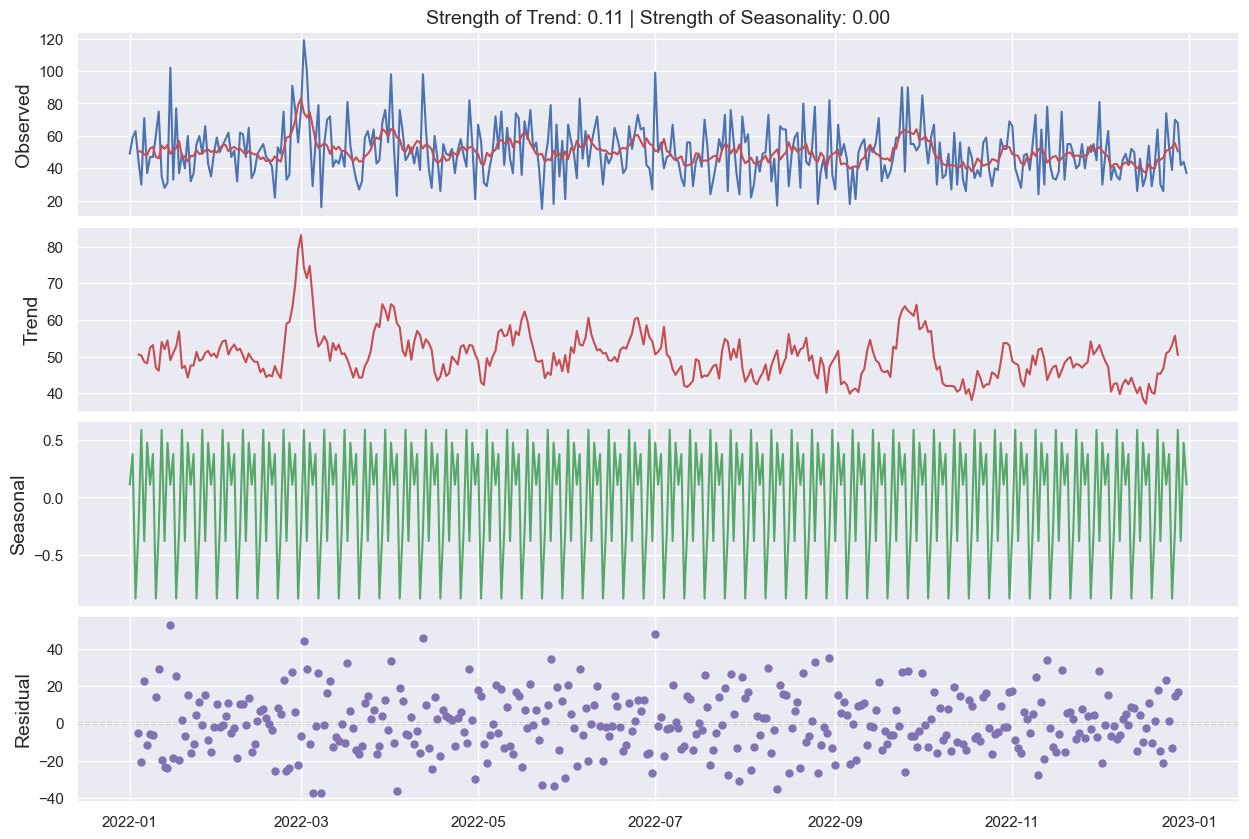

In [122]:
components = additive_decomposition(df_forecast, plot=True)

**Insight:**
Data tidak memiliki Trend dan seasonal

## 4.3 Uji stationary dengan ADF

In [123]:
# Membuta fungsi untuk mengecek stationarity
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [124]:
check_stationarity(df_forecast)

ADF Statistic: -19.448086
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
Stationary


**Insight:**
- Data Stationer

## 4.4 Uji Korelasi

<Axes: >

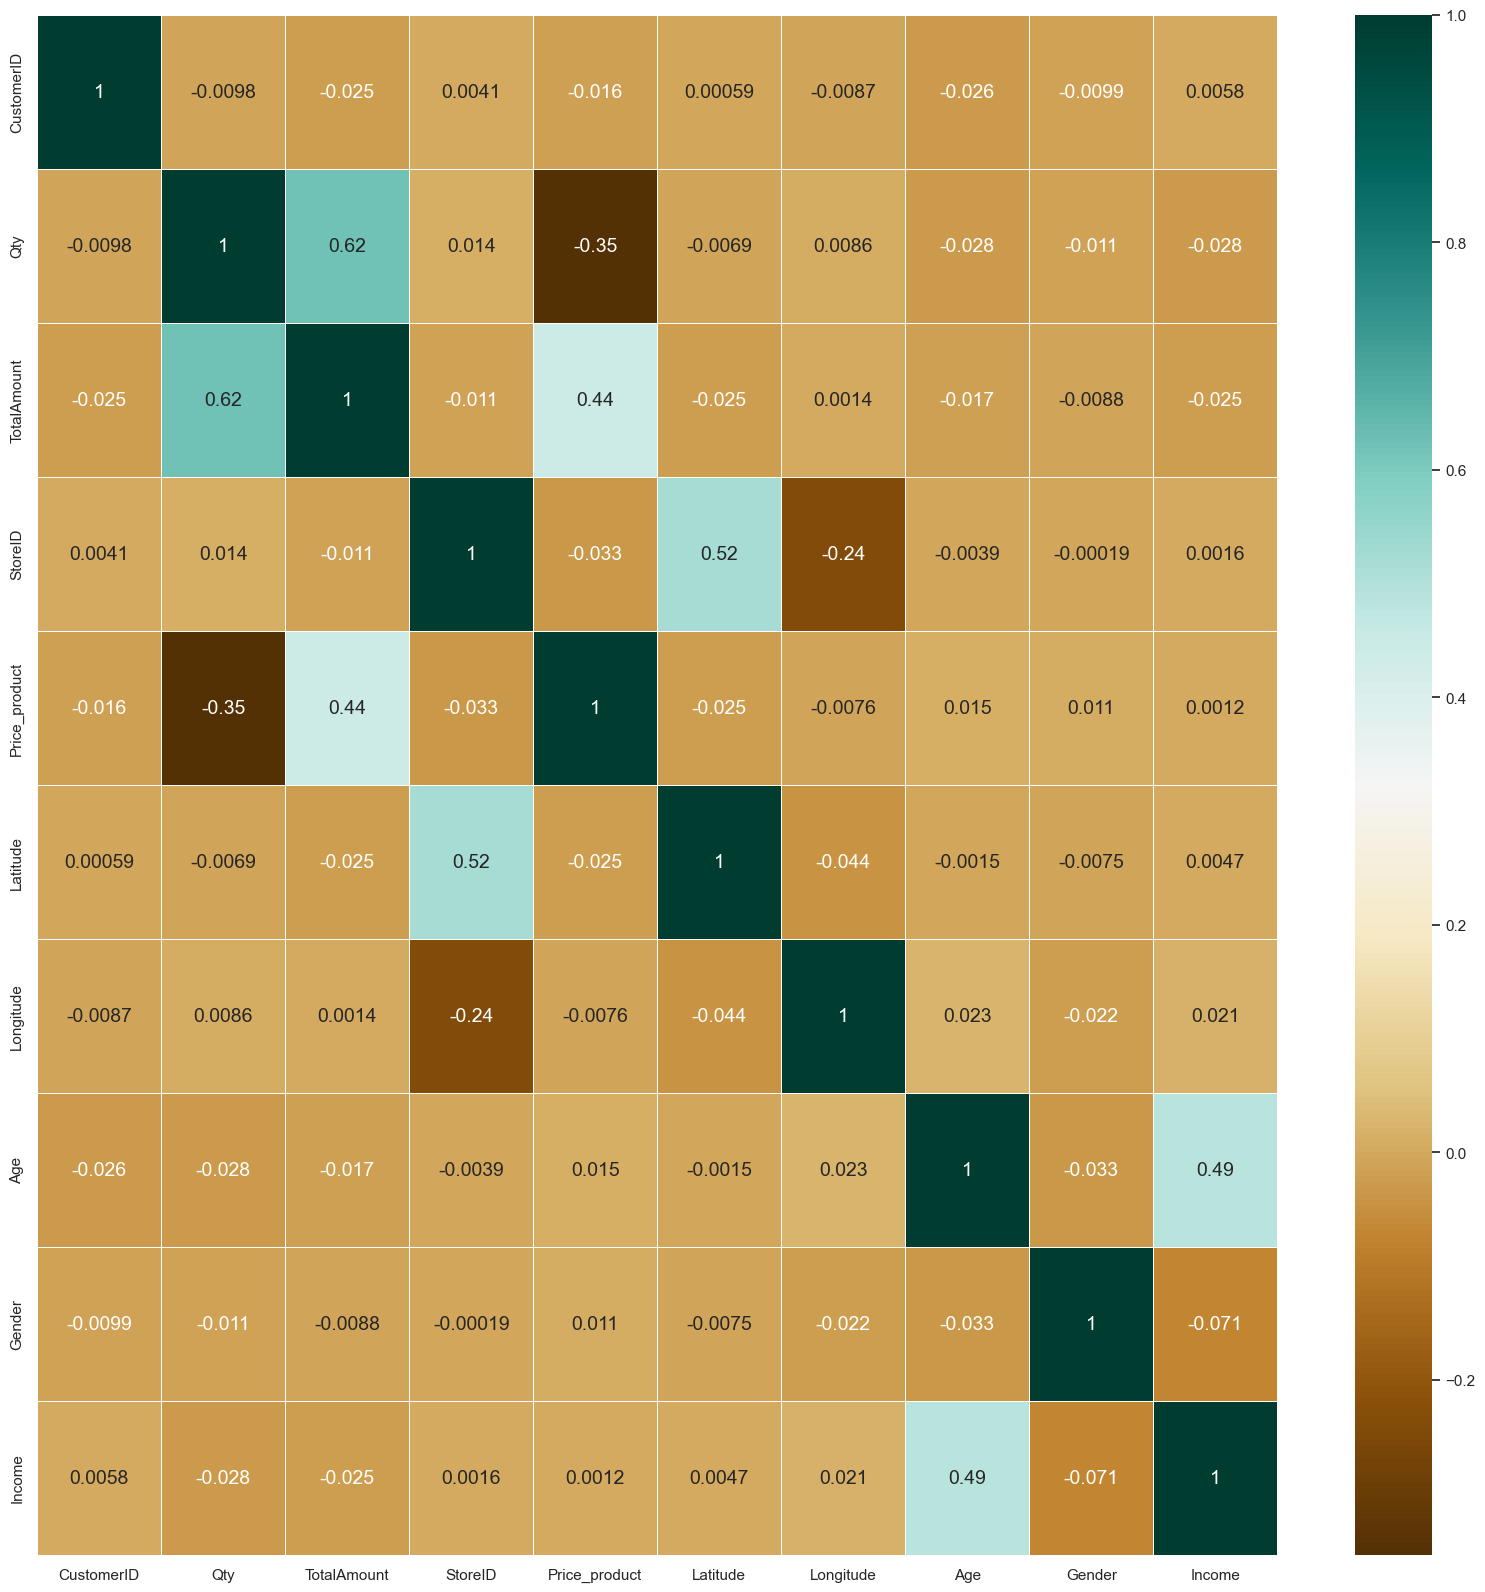

In [125]:
# Melihat korelasi dengan heatmap
df_numeric = df.select_dtypes(include='number')
plt.figure(figsize=(20,20))
sns.heatmap(df_numeric.corr(method='pearson'),
                cmap = 'BrBG',
                linewidths= .5,
                annot = True,
                annot_kws={'size':14})

Dari hasil heatmap pearson yang memiliki korelasi dengan TotalAmount adalah Price dan Qty

In [127]:
selected_df = df[['Qty', 'TotalAmount', 'Age', 'Income', 'Price_product']]

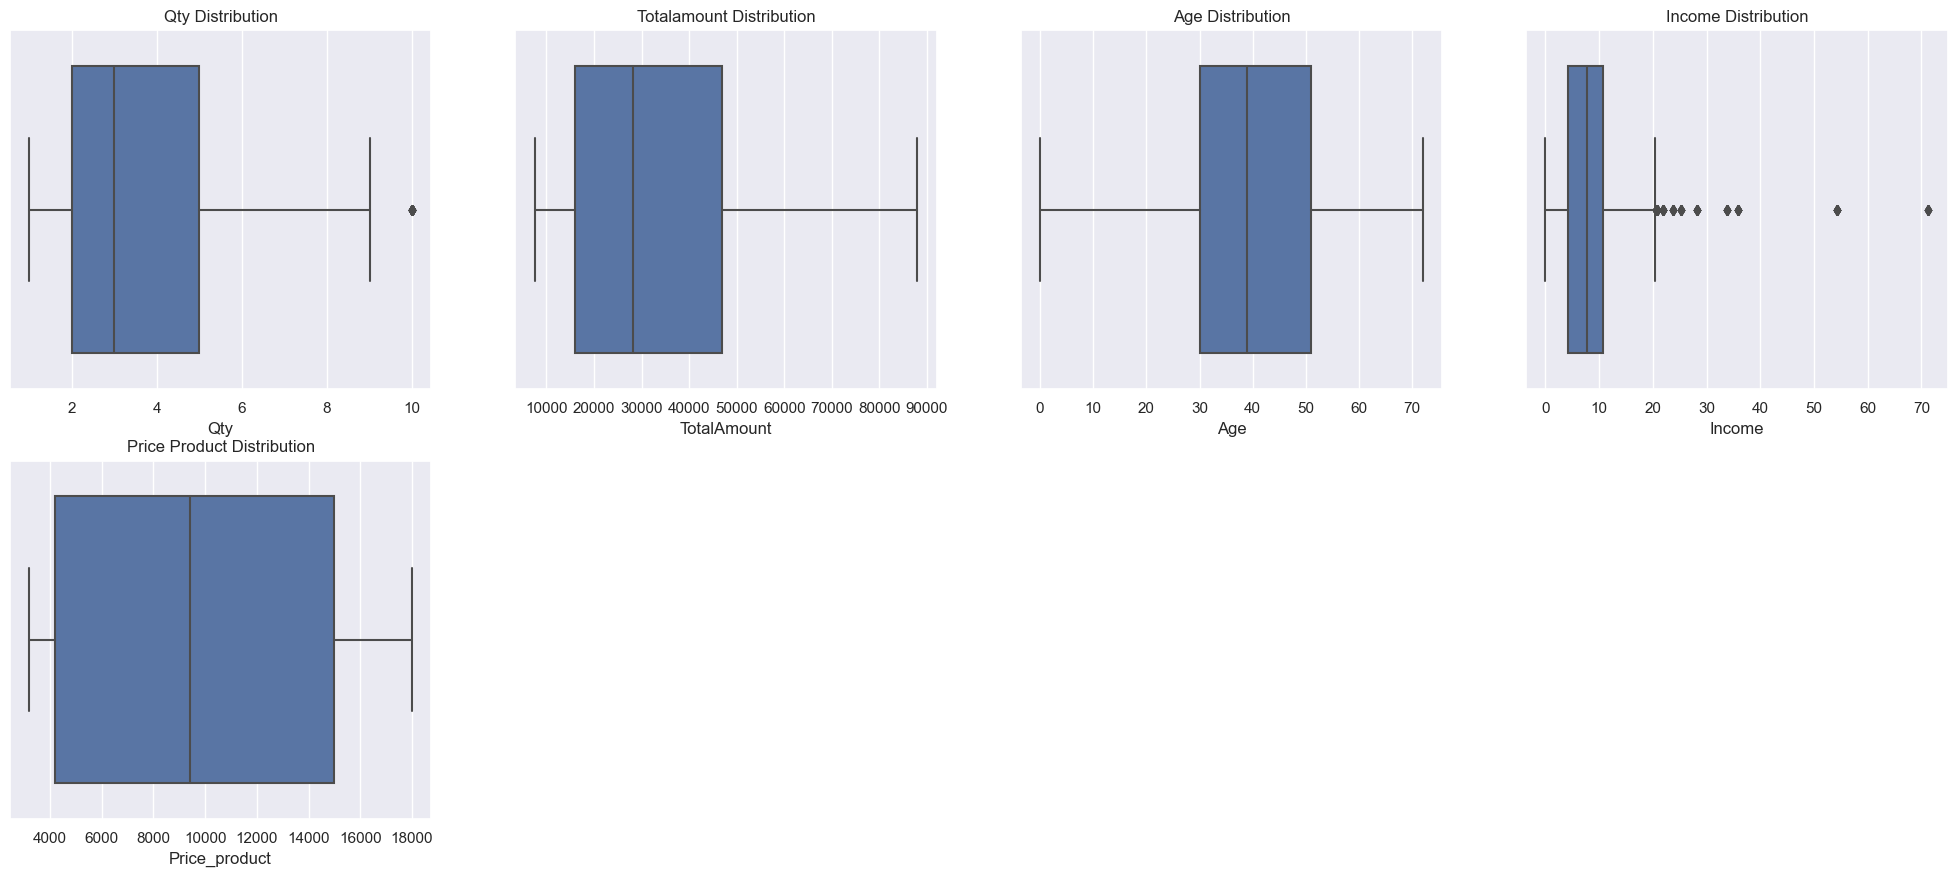

In [128]:
# Melihat visualisasi Boxplot
plt.figure(figsize=(25, 27))
for col in selected_df.columns:
    plt.subplot(5, 4, selected_df.columns.get_loc(col) + 1)
    sns.boxplot(x=col, data=selected_df)
    plt.title(f"{col.replace('_', ' ').title()} Distribution")
plt.show()

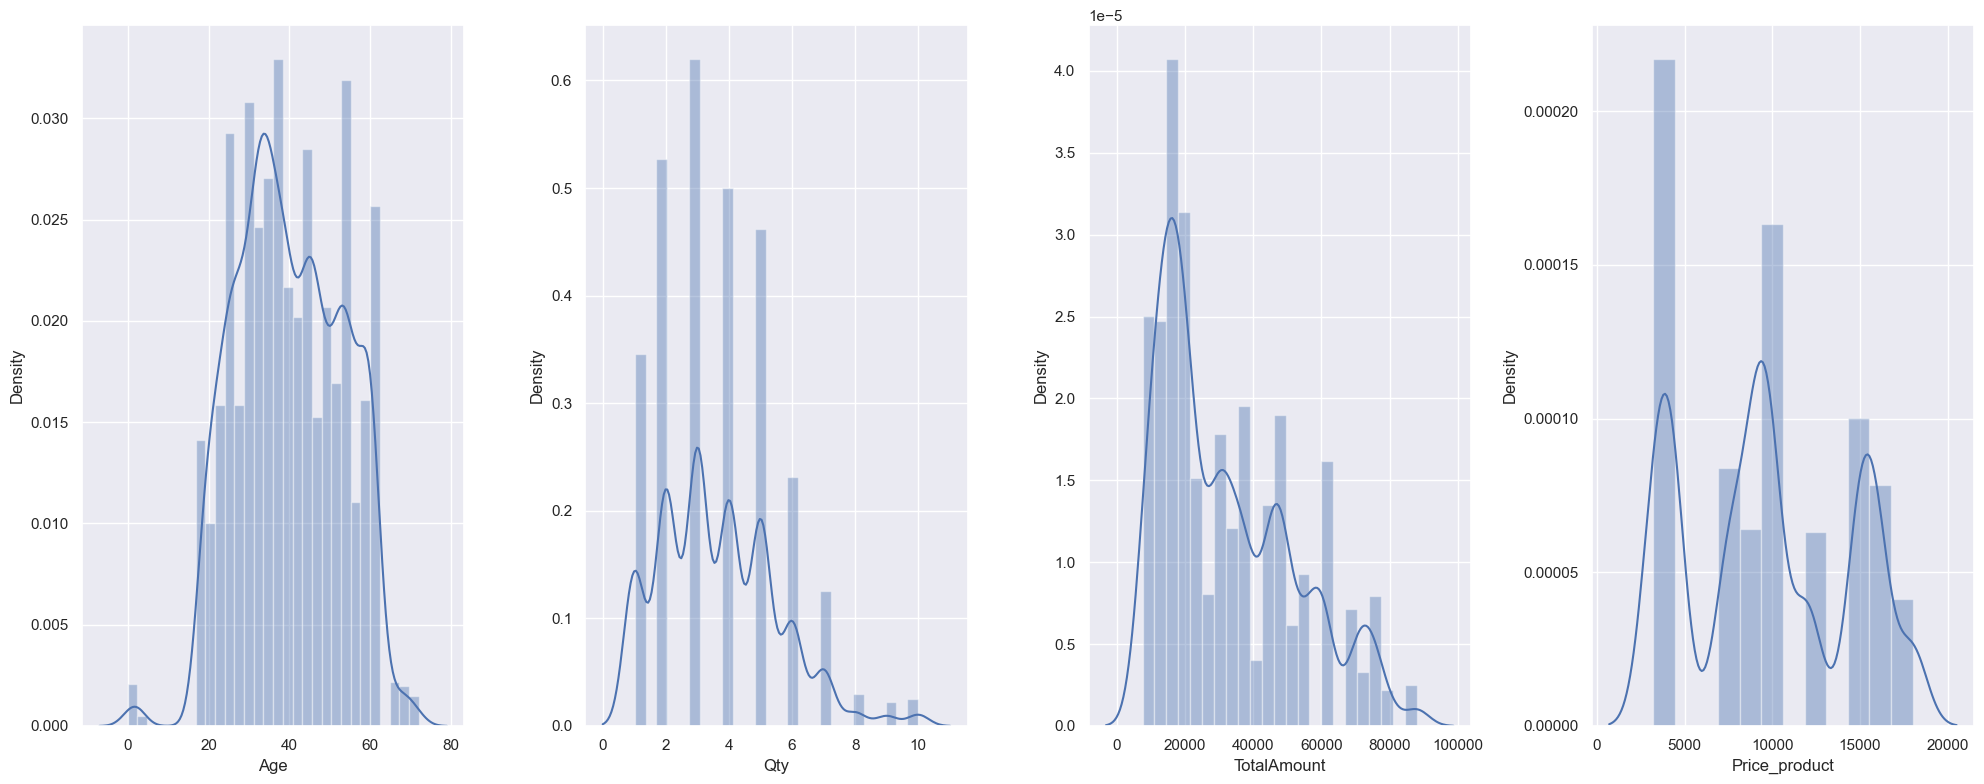

In [130]:
# Melihta Distribusi Data
# Distribution plots
plt.figure(figsize = (20, 8))
plotnumber = 1

for col in ['Age', 'Qty', 'TotalAmount','Price_product']:
    if plotnumber <= 4:
        ax = plt.subplot(1, 4, plotnumber)
        sns.distplot(df[col])
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

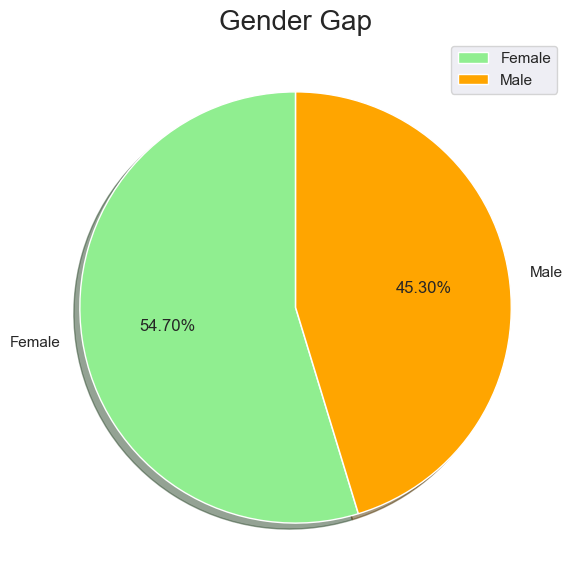

In [131]:
labels = ['Female', 'Male']
size = df['Gender'].value_counts()
colors = ['lightgreen', 'orange']
explode = [0, 0.001]

plt.figure(figsize = (10 , 7))
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, startangle = 90, autopct = '%.2f%%')
plt.title('Gender Gap', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

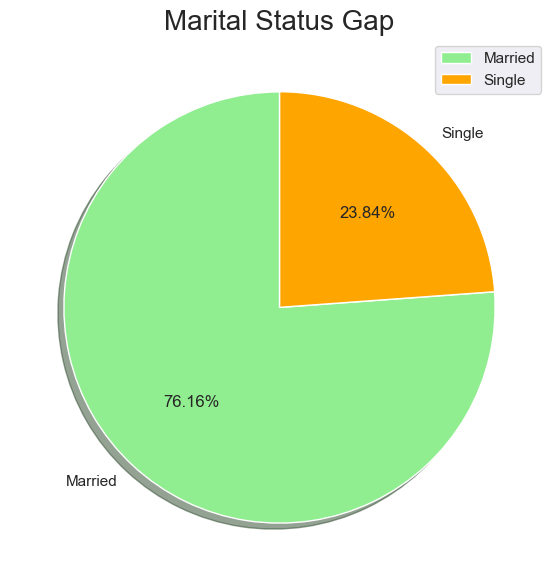

In [133]:
labels = ['Married', 'Single']
size = df['MaritalStatus'].value_counts()
colors = ['lightgreen', 'orange']
explode = [0, 0.001]

plt.figure(figsize = (10 , 7))
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, startangle = 90, autopct = '%.2f%%')
plt.title('Marital Status Gap', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

# 5. Pre-procesing Data

## 5.1 Data Inference

In [75]:
# Data inference cluster
data_inf = df.sample(5, random_state=42)
data_inf

,TransactionID,CustomerID,Date,ProductID,Qty,TotalAmount,StoreID,ProductName,Price_product,StoreName,GroupStore,Type,Latitude,Longitude,Age,Gender,MaritalStatus,Income
1504,TR49663,396,2022-10-04,P7,4,37600,8,Coffee Candy,9400,Sinar Harapan,Harapan Baru,General Trade,5.548290e+05,95323753.0,36,1,Married,9.18
538,TR47702,101,2022-05-05,P9,1,10000,7,Yoghurt,10000,Buana Indah,Buana,General Trade,3.316694e+06,114590111.0,61,1,Married,54.20
3551,TR1651,206,2022-08-18,P9,2,20000,11,Yoghurt,10000,Sinar Harapan,Prestasi,General Trade,5.335050e-01,101447403.0,68,0,Married,8.30
4945,TR17356,296,2022-06-18,P2,5,16000,5,Ginger Candy,3200,Bonafid,Gita,General Trade,-7.250445e+06,112768845.0,38,1,Single,3.18
4817,TR35699,35,2022-07-23,P8,2,32000,3,Oat,16000,Prima Kota,Prima,Modern Trade,-7.797068e+06,110370529.0,48,1,Married,10.58


In [76]:
# Memisahkan data inference dari dataset
df_train_test = df.drop(data_inf.index)
df_train_test.shape

(5015, 18)

In [77]:
# Reset index
df_train_test.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

## 5.2 Handling Missing Value

In [78]:
# Menghitung missing persentase missing value
missing_count = df['MaritalStatus'].isnull().sum()
total_rows = len(df)
missing_percentage = (missing_count/total_rows)*100
print(missing_percentage)

0.8764940239043826


In [79]:
# fill null values with mode method
mode_marital_status = df['MaritalStatus'].mode()[0]
df['MaritalStatus'].fillna(mode_marital_status, inplace = True)
df.isna().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Qty              0
TotalAmount      0
StoreID          0
ProductName      0
Price_product    0
StoreName        0
GroupStore       0
Type             0
Latitude         0
Longitude        0
Age              0
Gender           0
MaritalStatus    0
Income           0
dtype: int64

## Feature Selection

In [80]:
# Aggregat kolom Date dan Qty untuk Forecasting
df_forecast = df.groupby(['Date']).agg({'Qty': 'sum'}).reset_index()

# Set kolom Date menjadi index
df_forecast = df_forecast.set_index('Date')
df_forecast.head(3)

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63


In [81]:
# make new dataframe for clustering
df_cluster = df.groupby('CustomerID').agg({'TransactionID' : 'count',
                                          'Qty' : 'sum',
                                          'TotalAmount' : 'sum'})
df_cluster.head()

,TransactionID,Qty,TotalAmount
CustomerID,,,
1,17,60,623300
2,13,57,392300
3,15,56,446200
4,10,46,302500
5,7,27,268600


## 5.5 Split Data

In [82]:
# Split Train and test for forecasting
df_train_for, df_test_for = df_forecast[:-25], df_forecast[-25:]
print(f'Train Size: {df_train_for.shape}')
print(f'Test Size: {df_test_for.shape}')

Train Size: (340, 1)
Test Size: (25, 1)


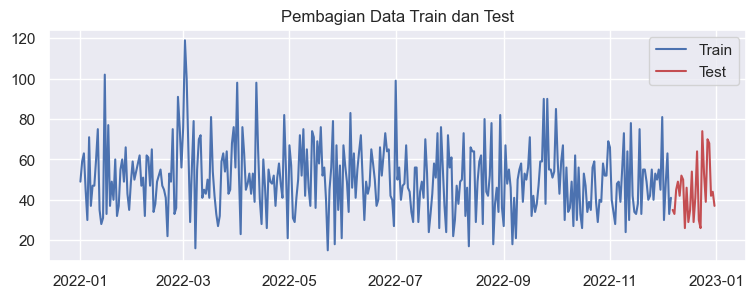

In [83]:
# Visualisasi Split Train and Test for Forecasting
plt.figure(figsize=(9,3))
plt.plot(df_train_for, 'b-', label='Train')
plt.plot(df_test_for, 'r-', label='Test')
plt.title('Pembagian Data Train dan Test')
plt.legend()
plt.show()

## 5.6 Feature Scaling

In [84]:
from sklearn.preprocessing import StandardScaler

In [85]:
# Standardize the Data
# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the data in df_cluster
df_cluster_std = scaler.fit_transform(df_cluster.values)

# Convert the standardized data back to a DataFrame
df_cluster_std = pd.DataFrame(df_cluster_std, columns=df_cluster.columns)

# check the df_cluster_std data
df_cluster_std.head()

,TransactionID,Qty,TotalAmount
0,1.779816,1.496527,2.094768
1,0.545884,1.261093,0.239269
2,1.162850,1.182615,0.672218
3,-0.379565,0.397833,-0.482047
4,-1.305014,-1.093251,-0.754347


In [86]:
# check null values
df_cluster_std.isnull().sum()

TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

# 6. Modeling

## 6.1 Forecasting

In [87]:
auto_arima = auto_arima(df_train_for, trace=True, suppress_warnings=True, random_state=32)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3126.271, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3023.998, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3124.271, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2992.530, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2950.880, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2942.825, Time=0.35 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2931.509, Time=0.27 sec


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2929.516, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2940.832, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2890.255, Time=0.30 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2888.397, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2889.411, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2889.959, Time=0.54 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2948.886, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2888.716, Time=0.32 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2891.901, Time=0.82 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 6.862 seconds


In [109]:
model_ar = auto_arima(df_train_for, m=14, seasonal=True, information_criterion='aicc',random_state=42)
n_range = len(df_test_for)

#predict data
pred_ar = model_ar.predict(n_range)

# concat hasil prediksi dengan tanggal
dates = pd.date_range(df_test_for.index[0], periods=n_range, freq='D')
pred_ar = pd.Series(pred_ar, index=dates)

In [111]:
pred_ar

2022-12-07    49.474880
2022-12-08    49.272760
2022-12-09    47.958975
2022-12-10    49.474880
2022-12-11    48.161096
2022-12-12    48.464277
2022-12-13    47.958975
2022-12-14    48.969579
2022-12-15    45.331407
2022-12-16    50.485484
2022-12-17    48.666398
2022-12-18    47.150493
2022-12-19    50.182303
2022-12-20    49.373820
2022-12-21    48.517346
2022-12-22    48.537772
2022-12-23    48.670544
2022-12-24    48.517346
2022-12-25    48.650117
2022-12-26    48.619478
2022-12-27    48.670544
2022-12-28    48.568412
2022-12-29    48.936087
2022-12-30    48.415214
2022-12-31    48.599051
Freq: D, dtype: float64

In [112]:
def plot_eval(X_train, X_test, pred):

    mae = mean_absolute_error(X_test, pred)
    mape = mean_absolute_percentage_error(X_test, pred)

    plt.figure(figsize=[9,3])
    plt.plot(X_train, 'b-', label='Train')
    plt.plot(X_test, 'r-', label='Test')
    plt.plot(pred, 'g--',label='Forecast')
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=16)
    plt.legend()
    plt.show()

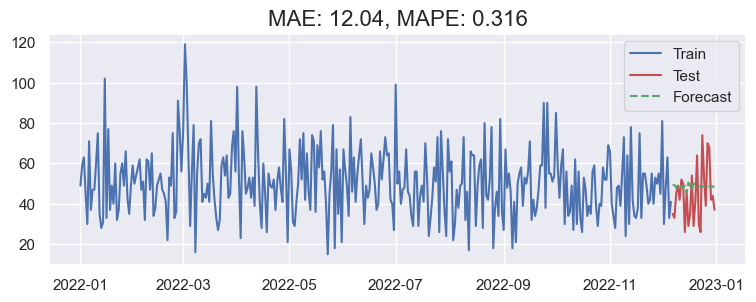

In [113]:
plot_eval(df_train_for,df_test_for,pred_ar)

# Clustering

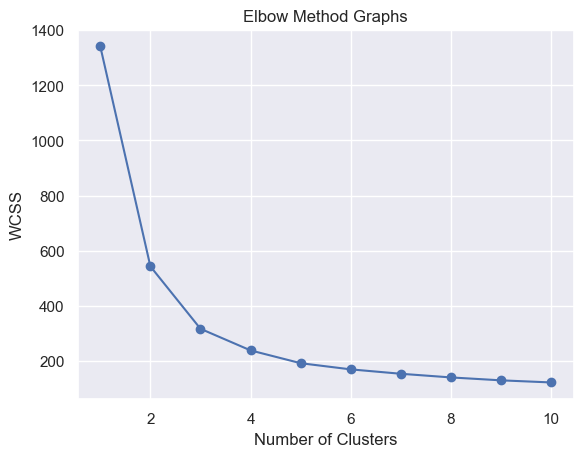

In [92]:
# plot the elbow method to get best number of clusters
wcss = [] # wcss is Within Cluster of Sum Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init = 10)
    kmeans.fit(df_cluster_std.values)
    wcss.append(kmeans.inertia_)

# plot the elbow method
sns.set()
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method Graphs')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [93]:
# make KMeans with n = 3
kmeans_3 = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0, n_init = 10)
clusters = kmeans_3.fit_predict(df_cluster_std)
df_cluster['cluster'] = clusters

# Display the DataFrame with the cluster labels
df_cluster.head()

,TransactionID,Qty,TotalAmount,cluster
CustomerID,,,,
1,17,60,623300,0
2,13,57,392300,0
3,15,56,446200,0
4,10,46,302500,1
5,7,27,268600,2


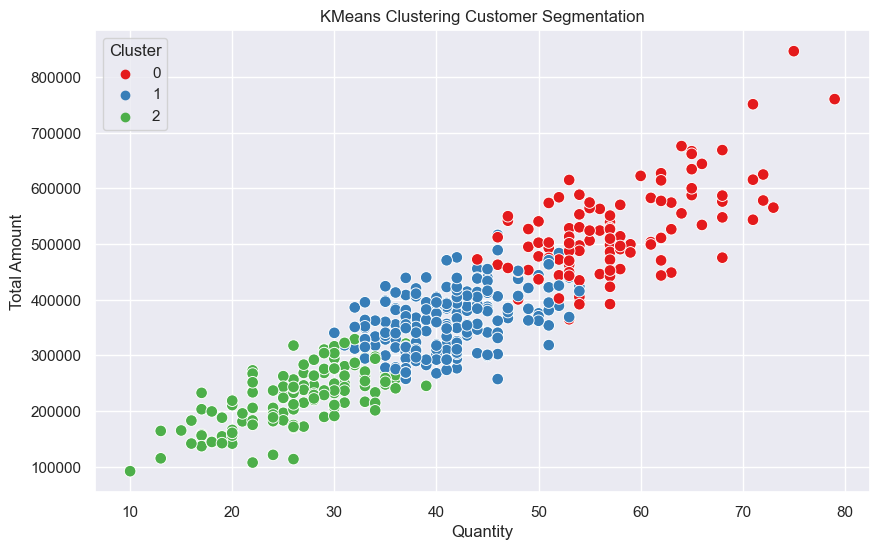

In [94]:
# Convert 'cluster' column to categorical data type
df_cluster['cluster'] = df_cluster['cluster'].astype('category')

# Create the scatter plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Qty', y='TotalAmount', data=df_cluster, hue='cluster', palette='Set1', s=70)
plt.xlabel('Quantity')
plt.ylabel('Total Amount')
plt.title('KMeans Clustering Customer Segmentation')
plt.legend(title='Cluster')
plt.show()

         TransactionID        Qty    TotalAmount
cluster                                         
0            15.363636  57.636364  524504.545455
1            11.282178  41.188119  363267.326733
2             7.785185  26.933333  229388.888889


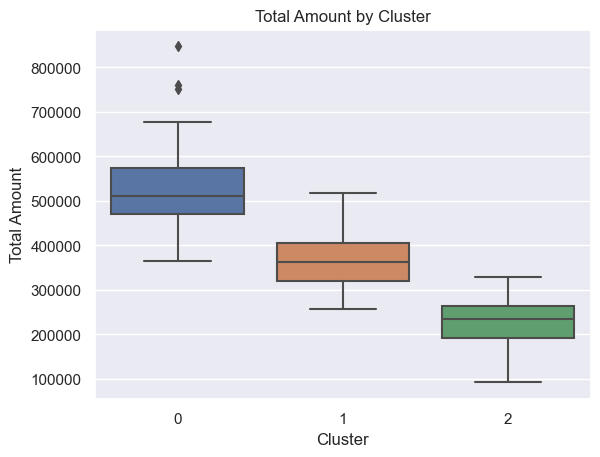

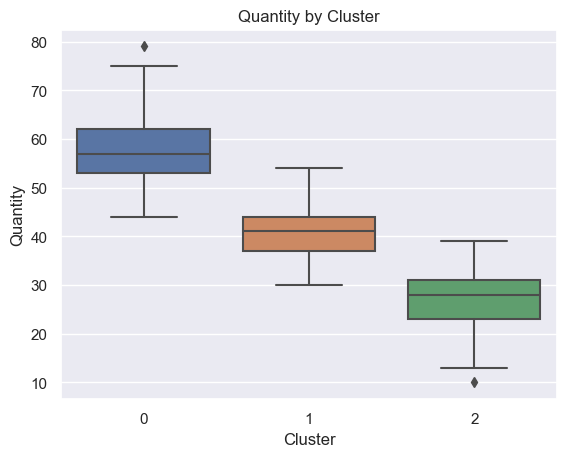

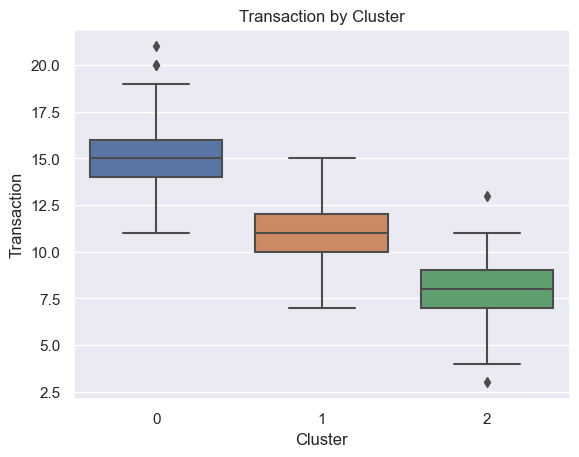

In [95]:
# checking cluster mean
cluster_mean = df_cluster.groupby('cluster').mean()
print(cluster_mean)

# Box Plot for total amount
sns.boxplot(data=df_cluster, x='cluster', y='TotalAmount')
plt.title('Total Amount by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Amount')
plt.show()

# Box Plot for Quantity
sns.boxplot(data=df_cluster, x='cluster', y='Qty')
plt.title('Quantity by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Quantity')
plt.show()

# Box Plot for Transaction
sns.boxplot(data=df_cluster, x='cluster', y='TransactionID')
plt.title('Transaction by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Transaction')
plt.show()

In [96]:
result = df_cluster.reset_index().groupby("cluster").agg({
    'CustomerID': 'count',
    'TransactionID': 'mean',
    'Qty': 'mean',
    'TotalAmount': 'mean'
}).reset_index()
result

,cluster,CustomerID,TransactionID,Qty,TotalAmount
0,0,110,15.363636,57.636364,524504.545455
1,1,202,11.282178,41.188119,363267.326733
2,2,135,7.785185,26.933333,229388.888889


### Model Evaluasi

In [97]:
#calculate the score
score = silhouette_score(df_cluster_std, kmeans_3.labels_, metric='euclidean')
print('Silhouette score: %.3f' % score)

Silhouette score: 0.429


# 7. Model Saving

In [98]:
# Model Saving
# Arima
with open ('model_ar.pkl', 'wb') as file_1:
    joblib.dump(model_ar, file_1)

# KMeans Clustering
with open ('kmeans_3.pkl', 'wb') as file_2:
    joblib.dump(kmeans_3, file_2)

# 8. Model Inference

## 8.1 Forecating

In [116]:
n_inf = len(df_test_for)+14
inf = model_ar.predict(n_inf)

dates = pd.date_range(df_test_for.index[0], periods=n_inf, freq='D')
inf = pd.Series(inf, index=dates)
inf = inf[len(df_test_for):]

# Convert to dataframe
inf = pd.DataFrame(inf)
inf = inf.rename(columns={0:'Sales'})
inf

,Sales
2023-01-01,48.752249
2023-01-02,48.445854
2023-01-03,48.527559
2023-01-04,48.614115
2023-01-05,48.612050
2023-01-06,48.598632
2023-01-07,48.614115
2023-01-08,48.600697
2023-01-09,48.603793
2023-01-10,48.598632


In [117]:
def plot_forecasting(X_train, X_test, inference):

    plt.figure(figsize=[9,3])
    plt.plot(X_train, 'b-', label='Train')
    plt.plot(X_test, 'r-', label='Test')
    plt.plot(inference, 'g--',label='Forecast')
    plt.title(f"Forecasting 14 Hari Kedepan")
    plt.legend()
    plt.show()

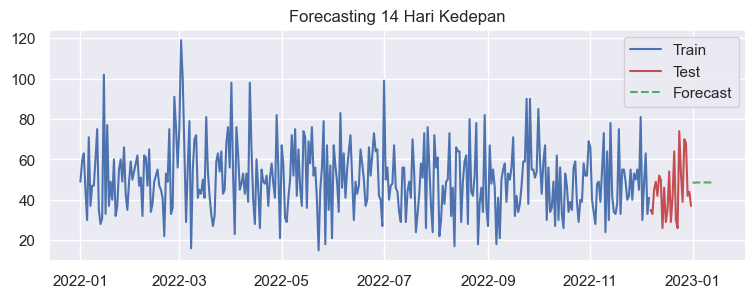

In [118]:
plot_forecasting(df_train_for, df_test_for, inf)

## 8.2 Clustering

In [99]:
kmeans_3 = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0, n_init = 10)
km_pred = kmeans_3.fit(df_cluster_std)

In [100]:
# make new dataframe for clustering
data_inf = data_inf.groupby('CustomerID').agg({'TransactionID' : 'count',
                                          'Qty' : 'sum',
                                          'TotalAmount' : 'sum'})
data_inf.head()

,TransactionID,Qty,TotalAmount
CustomerID,,,
35,1,2,32000
101,1,1,10000
206,1,2,20000
296,1,5,16000
396,1,4,37600


In [101]:
# Standardize the Data
# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the data in df_cluster
data_inf_std = scaler.fit_transform(data_inf.values)

# Convert the standardized data back to a DataFrame
data_inf_std = pd.DataFrame(data_inf_std, columns=data_inf.columns)

# check the df_cluster_std data
data_inf_std.head()

,TransactionID,Qty,TotalAmount
0,0.0,-0.544331,0.869846
1,0.0,-1.224745,-1.285178
2,0.0,-0.544331,-0.305622
3,0.0,1.496910,-0.697444
4,0.0,0.816497,1.418398


In [102]:
pred_data_inf = pd.Series(km_pred.predict(data_inf_std), name = 'Prediction')
pred_data_inf['cluster'] = clusters

# Reset index to ensure the indices match for concatenation
data_inf_reset = data_inf.reset_index(drop=True)
pred_data_inf_reset = pred_data_inf.reset_index(drop=True)

# Concatenate the original data_inf DataFrame and the pred_data_inf DataFrame along columns
result_df = pd.concat([data_inf_reset, pred_data_inf_reset], axis=1)

# Display the resulting DataFrame
print(result_df.head())

   TransactionID  Qty  TotalAmount Prediction
0            1.0  2.0      32000.0          1
1            1.0  1.0      10000.0          2
2            1.0  2.0      20000.0          1
3            1.0  5.0      16000.0          1
4            1.0  4.0      37600.0          0


# 8. Conclusion

## 8.1 Forecasting

1. Kinerja Model:
- MAE sebesar 12.04 (12 Kuantitas) artinya prediksi memiliki perkiraan error +- 12 unit/pcs.
- MAPE sebesar 0.316 (31.6%) menunjukan rata-rata kesalahan sekitar 31.6% dari nilai aktual hal ini tergolong masih tinggi. dan dilihat dari visualisasi bahwa garis prediksi tidak dapat sesuai dengan garik aktualnya.

Rekomendasi Bisnis
1. Penyesuaian Persediaan Harian:
- Dengan MAE yang telah diukur, tim inventory dapat menyesuaikan persediaan harian mereka dengan lebih akurat untuk menghindari kelebihan stok atau kekurangan stok yang signifikan. Pastikan bahwa stok yang dijaga mencerminkan prediksi yang telah dibuat.

2. Implementasi Safety Stock yang Dinamis:

- Gunakan hasil forecasting sebagai dasar untuk mengelola safety stock (stok cadangan). Dengan memahami tingkat ketidakpastian yang dinyatakan oleh MAE, tim inventory dapat mengoptimalkan tingkat safety stock untuk mengatasi ketidakpastian dalam prediksi.

3. Pengelolaan Overstock / Understock:

- Dengan memahami tingkat ketidakpastian yang dinyatakan oleh MAE dan MAPE, tim inventory dapat lebih proaktif dalam mengelola overstock atau understock. Evaluasi kebijakan diskon, promosi, atau program clearance untuk mengurangi dampak overstock yang berlebihan.

## 8.2 Clustering

1. Karakteristik Kluster:

Kluster 0: Terdiri dari 110 pelanggan dengan frekuensi transaksi rata-rata 15.36, kuantitas pembelian rata-rata 57.64, dan total pembelian rata-rata sekitar 524,504.55. Pelanggan dalam kluster ini memiliki aktivitas belanja yang tinggi.

Kluster 1: Terdiri dari 202 pelanggan dengan frekuensi transaksi rata-rata 11.28, kuantitas pembelian rata-rata 41.19, dan total pembelian rata-rata sekitar 363,267.33. Pelanggan dalam kluster ini memiliki aktivitas belanja yang sedang.

Kluster 2: Terdiri dari 135 pelanggan dengan frekuensi transaksi rata-rata 7.79, kuantitas pembelian rata-rata 26.93, dan total pembelian rata-rata sekitar 229,388.89. Pelanggan dalam kluster ini memiliki aktivitas belanja yang relatif rendah.

2. Segmentasi Pelanggan:

High-Value Customers (Kluster 0): Pelanggan dalam kluster ini menunjukkan tingkat aktivitas belanja yang tinggi dengan frekuensi transaksi dan total pembelian rata-rata yang signifikan. Mereka mungkin merupakan pelanggan yang sangat berharga bagi bisnis.

Medium-Value Customers (Kluster 1): Pelanggan dalam kluster ini menunjukkan aktivitas belanja yang sedang. Meskipun mereka tidak seaktif kluster 0, mereka masih berkontribusi cukup signifikan terhadap pendapatan.

Low-Value Customers (Kluster 2): Pelanggan dalam kluster ini memiliki aktivitas belanja yang relatif rendah. Mungkin perlu strategi khusus untuk meningkatkan keterlibatan mereka.

Rekomendasi Bisnis:
1. Promosi dan Penjualan yang Dipersonalisasi:

High-Value Customers: Tim pemasaran dapat fokus pada pelanggan kluster 0 dengan menawarkan promosi eksklusif, diskon besar, atau keuntungan tambahan untuk meningkatkan loyalitas mereka.

Medium-Value Customers: Sementara pelanggan kluster 1 telah menunjukkan tingkat aktivitas belanja yang baik, tim pemasaran dapat memberikan insentif tambahan untuk mendorong mereka meningkatkan frekuensi transaksi atau nilai pembelian.

Low-Value Customers: Untuk pelanggan kluster 2, tim pemasaran dapat merancang strategi untuk meningkatkan keterlibatan, seperti penawaran khusus untuk meningkatkan minat mereka dalam berbelanja.

2. Program Loyalitas:

Menerapkan program loyalitas yang berfokus pada penghargaan dan keuntungan khusus untuk pelanggan kluster 0 untuk mempertahankan tingkat aktivitas belanja mereka.

3. Analisis Produk Populer:

Menganalisis produk atau kategori produk yang paling diminati oleh masing-masing kluster dan memastikan persediaan yang memadai serta menawarkan promosi khusus pada produk tersebut.

4. Follow-Up Pelanggan:

Menggunakan data kluster untuk mengidentifikasi pelanggan yang mungkin berisiko meninggalkan bisnis dan melakukan follow-up khusus untuk memahami kebutuhan dan kekhawatiran mereka.

## 8.3 Futhur Improvment

1. Optimalkan Model Forecasting dan Clustering
- Gunakan teknik analisis atau machine learning lainnya untuk meningkatkan akurasi prediksi
2. Integritas Data Eksternal:
- Seperti menambahkan data hari libur, event yang dapat mempengaruhi penjualan produk
3. Analisis Musiman:
- Lakukan analisis musiman untuk memahami pola penjualan yang berkaitan dengan musim atau peristiwa khusus. Hal ini memungkinkan tim inventory untuk lebih efektif mengelola stok persediaan selama periode tertentu.